In [1]:
%matplotlib inline

In [2]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats.mstats import gmean

In [3]:
import sys; sys.path.insert(0, '../')
from gp_inspection import extract_metric_evolution
from gp_experiments import rescale_linear

/usr/lib/python2.7/dist-packages/matplotlib/__init__.py:1352: UserWarning:  This call to matplotlib.use() has no effect
because the backend has already been chosen;
matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

  warnings.warn(_use_error_msg)


In [4]:
paths = [
    ('Venture'           , '../resources/reports/stamp@20181102-155157_shortname@vs-euHdZTNmNT_ntest@20_iters@5_epochs@200_schedule@constant_seed@1387012777.merged.report.csv'),
    ('Gen (naive)'       , '../resources/reports/stamp@20181102-174139_shortname@lightweight-Mzc0ZW_ntest@20_iters@5_epochs@400_schedule@constant_seed@945467991.merged.report.csv'),
    ('Gen (incremental)' , '../resources/reports/stamp@20181104-141136_shortname@incremental-iOpZa_ntest@20_iters@5_epochs@400_schedule@constant_seed@4027282976.merged.report.csv'),
    ('Handcoded (naive)' , '../resources/reports/stamp@20181104-143323_shortname@handcoded-iZaMk_ntest@20_iters@5_epochs@400_schedule@constant_seed@1788702245.merged.report.csv'),
]

In [5]:
def plot_evolution_one(runtimes, metrics, label, color, ax):
    runtimes = runtimes[1:]
    metrics = metrics[1:]
    #  Some filtering.
    # keep = np.argsort(metrics[-1,:])[:-10]
    # metrics = metrics[:, keep]
    # runtimes = runtimes[:,keep]
    #  Computing metrics to plot.
    x_runtime = np.cumsum(np.median(runtimes, axis=1))
    y_metric_median = np.mean(metrics, axis=1)
    y_metric_high = np.percentile(metrics, 75, axis=1)
    y_metric_low = np.percentile(metrics, 25, axis=1)
    # Plot.
    ax.errorbar(x_runtime, y_metric_median,
        # yerr=[y_metric_median-y_metric_low, y_metric_high-y_metric_median],
        fmt='--.', 
        label=label, color=color)
    return ax

In [6]:
metric = 'rmse'

In [7]:
import matplotlib
matplotlib.rcParams['text.usetex'] = False

/usr/lib/python2.7/dist-packages/matplotlib/figure.py:1744: UserWarning: This figure includes Axes that are not compatible with tight_layout, so its results might be incorrect.
  warnings.warn("This figure includes Axes that are not "


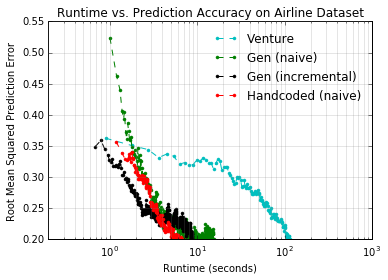

In [8]:
fig, ax = plt.subplots()
colors = ['c', 'g', 'k', 'r']
for i, (method, path) in enumerate(paths):
    runtimes, metrics = extract_metric_evolution(path, 'runtime', metric)
    ax = plot_evolution_one(runtimes, metrics, method, colors[i], ax)

ax.set_title('Runtime vs. Prediction Accuracy on Airline Dataset')
ax.set_ylabel('Root Mean Squared Prediction Error')
ax.set_xlabel('Runtime (seconds)')
ax.legend(loc='upper right', framealpha=0)
ax.grid(which='both', linestyle='-', linewidth=1, color='gray', alpha=.2)
ax.set_xscale('log')
ax.set_xlim([2*10**-1, 10**3])
ax.set_ylim([0.2, None])
fig.set_facecolor('white')
fig.set_tight_layout(True)
fig.set_size_inches(5.5, 4)
# fig.savefig('airline-gen-venturescript-runtime-rmse.png')